### This Notebook will be mainly used for the capstone project

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests

In [2]:
#!pip install beautifulsoup4

In [3]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


# **Week 3** 
## Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto  
### **Section 1**

- *Collect data from wikipedia article*

In [4]:
html_file = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(html_file, 'lxml')

- *Search for tables in the html file, and grab the table at index 0, this time we only have one table,but this could be apply also if multiple table exist inside of the same page.*

In [5]:
table = soup.find_all('table')[0]

- *Read html file with pandas, convert it to a Dataframe and Rename the first column from Postcode to PostalCode*

In [6]:
table_list = pd.read_html(str(table))
df = pd.DataFrame(table_list[0])
df.rename(columns={'Postcode':'PostalCode', 'Neighbourhood':'Neighborhood'}, inplace=True)
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

- *Dataframe including Borough Not assigned*

In [7]:
df.describe()

,PostalCode,Borough,Neighborhood
count,288,288,288
unique,180,12,209
top,M8Y,Not assigned,Not assigned
freq,8,77,78


- **Dataframe after using a boolean condition to remove the rows where Borough was Not assigned**

In [8]:
df_ba = df[df['Borough'] != 'Not assigned']
df_ba.describe()

,PostalCode,Borough,Neighborhood
count,211,211,211
unique,103,11,209
top,M8Y,Etobicoke,Runnymede
freq,8,45,2


### More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

- *I used the groupby function to group the data by 'PostalCode', 'Borough' and applied a string join function, concatenating with a ',' the values located in the 'Neighbourhood' column, to avoid the values being overwritten, also I converted to a Dataframe using Series.to_frame method, and reset the index to bring back the new dataframe with the same column structure.*

In [9]:
df_ba_clean = df_ba.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(','.join).to_frame().reset_index()

In [10]:
df_ba_clean.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.

- *Collected the list of index where 'Neighbourhood' value was 'Not assigned', and then use the Index locations to replace the values of the 'Neighbourhood' column by the values of the 'Borough' by using DataFrame Slicing (This time just one value was returned by the condition).*

In [11]:
index_loc = df_ba_clean[df_ba_clean['Neighborhood'] == 'Not assigned']['Neighborhood'].index

In [12]:
df_ba_clean.loc[index_loc, 2:] = df_ba_clean.loc[index_loc]['Borough'].values[0]

In [13]:
df_ba_clean.loc[index_loc]

,PostalCode,Borough,Neighborhood
85,M7A,Queen's Park,Queen's Park


### In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [14]:
df_ba_clean.shape

(103, 3)

<hr></hr>

### **Section 2**

- *I Read Geospatial data from csv file, then rename the Postal Code column to PostalCode, to match the Column name of the Neighbourhood DataFrame, then I grouped by the data by PostalCode to get the unique values and get a dimension match between the two dataframes, and then I merge the two data frames doing a join on the PostalCode column.*

In [15]:
geo_data = pd.read_csv('Geospatial_Coordinates.csv')
geo_data.rename(columns={'Postal Code':'PostalCode'}, inplace=True)

In [16]:
geo_data = geo_data.groupby('PostalCode').head()

In [17]:
geo_data.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [18]:
df_final = pd.merge(df_ba_clean, geo_data, on='PostalCode')

In [19]:
df_final.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<hr></hr>

### **Section3**

- *I use KMeans to run a Cluster between the Longitude, the number of cluster used was 6, after that I created a scatter plot of the results of the clustering, and I noticed that our clusters are subdivided in a pattern section which seems to match what a group of neighborhoods would look like, each cluster is next to each other and then there is another cluster following, same structure we could see in the cities.*

In [21]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [23]:
X = df_final[['Latitude', 'Longitude']]
X = StandardScaler().fit(X).transform(X.astype(float))

In [24]:
kmeans_model = KMeans(n_clusters=6, random_state=20, max_iter=25).fit(X)
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

In [25]:
metrics.silhouette_score(X, kmeans_model.labels_, metric='euclidean')

0.3880708857660392

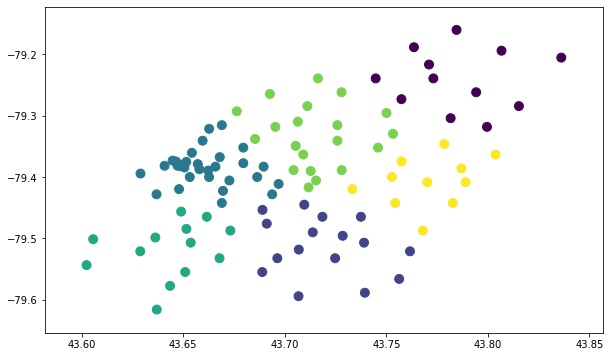

In [26]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_final['Latitude'], df_final['Longitude'], s=80, c=labels, cmap='viridis')

In [27]:
df_final['Cluster'] = labels

In [28]:
df_final.head(20)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,0
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,4
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,4
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,4
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,4


### **Ploting the Neighborhoods clusters in folium**

- *To plot the Clusters in Folium I used the pluging provided by folum 'MarkerCluster'*

In [29]:
import folium
from folium.plugins import MarkerCluster

In [30]:
toronto_map = folium.Map(location=(43.653, -79.383), zoom_start=10)

mc = MarkerCluster()

#creating a Marker for each point in df_final. Each point will get a popup with their Borough
for row in df_final.itertuples():
    mc.add_child(folium.Marker(location=[row.Latitude,  row.Longitude],
                 popup=row.Borough))

toronto_map.add_child(mc)


toronto_map